In [16]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import torch
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import pyro
from pyro.infer.autoguide import AutoLaplaceApproximation, AutoIAFNormal, AutoMultivariateNormal, AutoNormalizingFlow, AutoDiagonalNormal, AutoDelta, init_to_mean
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Predictive, MCMC, NUTS
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints

In [3]:
import sys
sys.path.append("../")

In [14]:
from models.likelihoods import log_like_np
from models.nptf_model import NPRegression
from utils.templates import get_NFW2_template
from utils.psf_correction import PSFCorrection
from utils import create_mask as cm
from models.psf import KingPSF

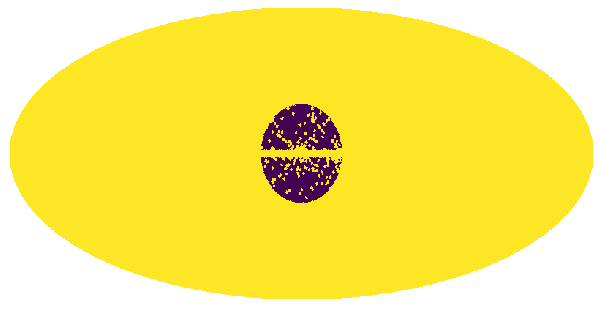

In [11]:
nside = 128
ps_mask = hp.ud_grade(np.load("../data/mask_3fgl_0p8deg.npy") > 0, nside_out=nside)

mask = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                          mask_ring = True, inner = 0, outer = 25, 
                          custom_mask=ps_mask)

hp.mollview(mask,title='',cbar=False,min=0,max=1)

In [20]:
# Load templates
temp_gce = get_NFW2_template(gamma=1.2)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")
fermi_data = np.load("../data/fermi_data/fermidata_counts.npy")

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)

In [42]:
npr = NPRegression(poiss_temps=[temp_iso, temp_bub, temp_psc, temp_dif, temp_gce],
            poiss_priors=[dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
#                           dist.Normal(torch.tensor(13.), torch.tensor(3.)),
                          dist.Uniform(torch.tensor(11.), torch.tensor(20.)),
                          dist.Uniform(torch.tensor(-8.), torch.tensor(-1.))],
            poiss_log_priors=torch.tensor([0., 0., 0., 0., 1.]),
            ps_temps=[temp_gce / np.mean(temp_gce)],
            ps_priors=[[dist.Uniform(torch.tensor(-8.), torch.tensor(-1.)), 
                        dist.Uniform(torch.tensor(11.0), torch.tensor(20.0)), 
                        dist.Uniform(torch.tensor(0.1), torch.tensor(1.99)), 
                        dist.Uniform(torch.tensor(-10.0), torch.tensor(1.99)), 
                        dist.Uniform(torch.tensor(11.), torch.tensor(100.)), 
                        dist.Uniform(torch.tensor(-3.), torch.tensor(1.))]],
            ps_log_priors=torch.tensor([[1., 0., 0., 0., 0., 1.]]),
            data = torch.tensor(fermi_data, dtype=torch.float64),
            labels_poiss=["iso", "bub", "psc", "dif", "gce"],
            labels_ps=["gce"],
            mask=mask,
            subsample_size=600)

../models/nptf_model.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)


In [46]:
pyro.clear_param_store()

In [47]:
guide = AutoMultivariateNormal(npr.model, init_loc_fn=init_to_mean)

In [48]:
elbo = TraceGraph_ELBO()
optimizer = optim.Adam({"lr": 1e-2})

In [54]:
num_iterations = 4000

svi = SVI(npr.model,
          guide,
          optimizer,
          loss=elbo)

for j in range(num_iterations):
    loss = svi.step()    
    if j % 5 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(fermi_data)))

In [51]:
num_samples = 50

predictive = Predictive(npr.model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in (predictive().items())
               if k != "obs"}


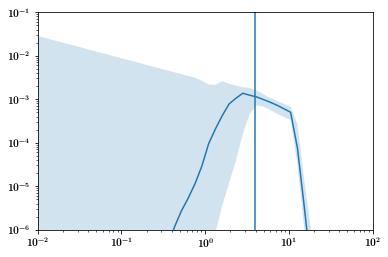

In [53]:
from models.scd import dnds
samplez = np.transpose([svi_samples[key] for key in svi_samples.keys()])
samplez[:,5] = 10 ** samplez[:,5]
samplez[:,-1] = 10 ** samplez[:,-1]
s_ary = np.logspace(-2, 2)
dnds_ary = [dnds(torch.tensor(s_ary), torch.tensor(s)).detach().numpy() for s in samplez[:,5:]]
plt.plot(s_ary, np.median(dnds_ary, axis=0))
plt.fill_between(s_ary, np.percentile(dnds_ary, [5.], axis=0)[0], np.percentile(dnds_ary, [95.], axis=0)[0], alpha=0.2)
# theta_sim = torch.tensor([4000., 20., 1.8, -20., 30., 1.])
# plt.plot(s_ary, dnds(torch.tensor(s_ary), theta_sim).detach().numpy() / len(data))
plt.xlim(1e-2, 1e2)
plt.ylim(1e-6, 1e-1)
plt.axvline(np.sqrt(np.mean(fermi_data[~mask])))

plt.xscale("log")
plt.yscale("log")
